In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import gc
import lightgbm as lgb
%matplotlib inline
print("Libraries imported")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries imported
/kaggle/input/widsdatathon2023/train_data.csv
/kaggle/input/widsdatathon2023/test_data.csv
/kaggle/input/widsdatathon2023/sample_solution.csv


### ^ These imports are becoming messy :^(

# Loading the data into variables cc_train, cc_test, cc_sample

- cc_train = /kaggle/input/widsdatathon2023/train_data.csv
- cc_test = /kaggle/input/widsdatathon2023/test_data.csv
- cc_sample = /kaggle/input/widsdatathon2023/sample_solution.csv

In [2]:
cc_train = pd.read_csv('/kaggle/input/widsdatathon2023/train_data.csv')
cc_test = pd.read_csv('/kaggle/input/widsdatathon2023/test_data.csv')
cc_sample = pd.read_csv('/kaggle/input/widsdatathon2023/sample_solution.csv')

# Reducing the memory usage of the dataset

## Acknowledgement

[Reduce Dataframe size](https://www.kaggle.com/competitions/widsdatathon2023/discussion/376649)

In [3]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [4]:
cc_train = reduce_mem_usage(cc_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


# Overview of the dataset

Using shape, info, head, describe

In [5]:
train_df = cc_train.copy()
test_df = cc_test.copy()

## Visualise the time gap between the train and the test data

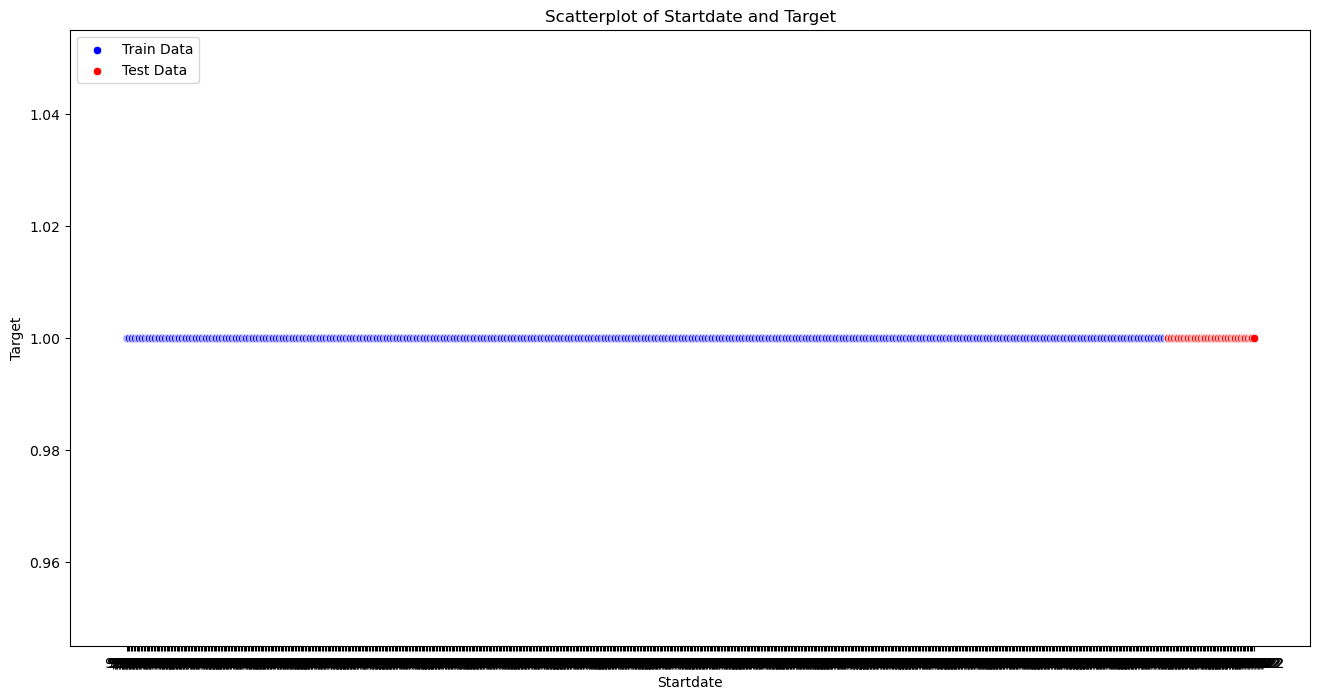

In [6]:
# create a scatterplot using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
sb.scatterplot(x=train_df.startdate, y=1, color='blue', label='Train Data', ax=ax)
sb.scatterplot(x=test_df.startdate, y=1, color='red', label='Test Data', ax=ax)

# add labels and a title to the plot
ax.set_title('Scatterplot of Startdate and Target')
ax.set_xlabel('Startdate')
ax.set_ylabel('Target')
ax.legend(loc='upper left')

# display the plot
plt.show()


**Based on the graph above the train data was from 2014 - 2016 and the test data is from 2022. There is a big time gap between the train and test data.**

## Analyising the distribution of values in both the train and test dataset

In [7]:
def dist_of_train_test_features(train_df, test_df, feature):
    # Analyse the distribution of values in the training dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=train_df, x=feature, kind='kde', label='Train Data')

    # Analyse the distribution of values in the testing dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=test_df, x=feature, kind='kde', label='Test Data')
# dist_of_train_test_features(train_df, test_df, 'nmme0-tmp2m-34w__nmme0mean')

In [8]:
cc_train.shape

(375734, 246)

In [9]:
cc_train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.272059,198.085175,10.952416,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201508,38.458878,25.288525,31.946749,34.164677,27.050356,25.847456,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [10]:
cc_test.shape

(31354, 245)

In [11]:
cc_sample.describe()

,contest-tmp2m-14d__tmp2m,index
count,31354.000000,31354.000000
mean,25.006322,391410.500000
std,2.891139,9051.264507
min,20.000011,375734.000000
25%,22.503063,383572.250000
50%,25.030905,391410.500000
75%,27.511672,399248.750000
max,29.997898,407087.000000


# Visualizing the target variable
`contest-tmp2m-14d__tmp2m`

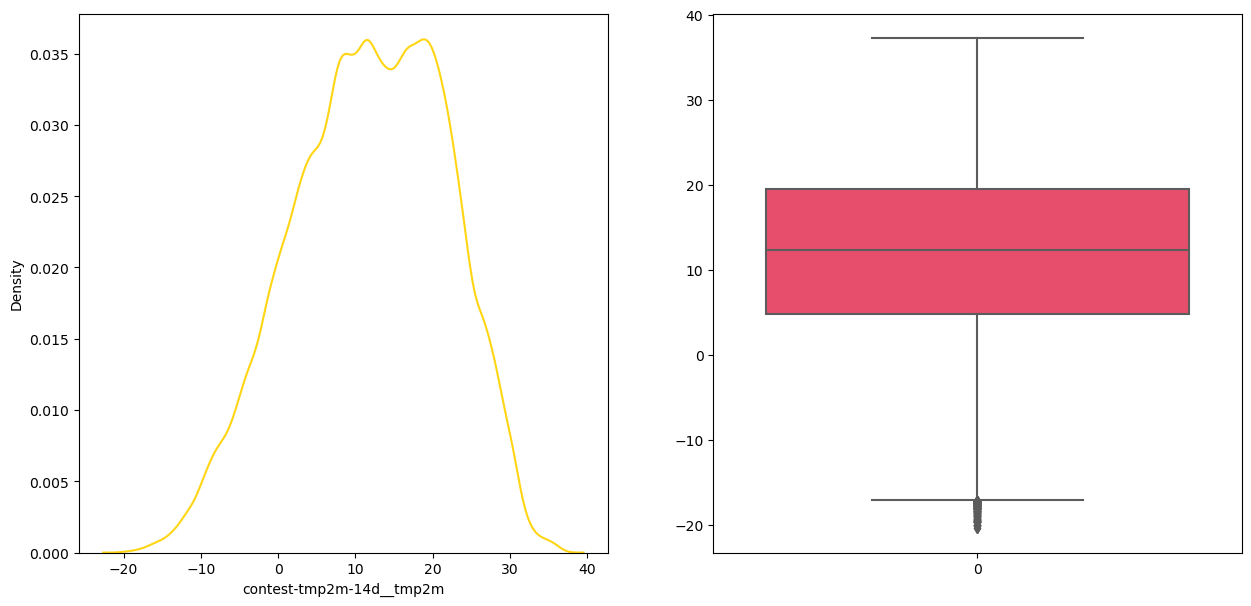

In [12]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()

## Displaying the distribution of the target variable in the train and test

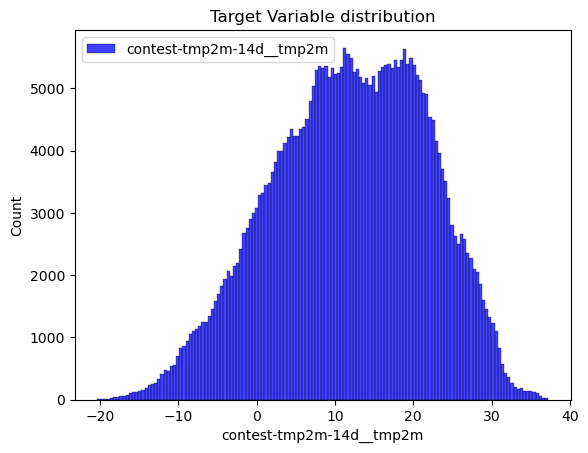

In [13]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")

**The target variable is not in the test dataset**

### Simple for loop to list out the features from the train dataset

In [14]:
'''
test_col = cc_test.columns
count = 0
for name in test_col:
  if count % 50 == 0:
    print()
  print(name + ', ', end='')
  count += 1
'''

"\ntest_col = cc_test.columns\ncount = 0\nfor name in test_col:\n  if count % 50 == 0:\n    print()\n  print(name + ', ', end='')\n  count += 1\n"

In [15]:
cc_train.columns[cc_train.isna().any()].tolist()

['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3',
 'ccsm30']

In [16]:
cc_test.columns[cc_test.isna().any()].tolist()

[]

In [17]:
cc_sample.columns[cc_sample.isna().any()].tolist()

[]

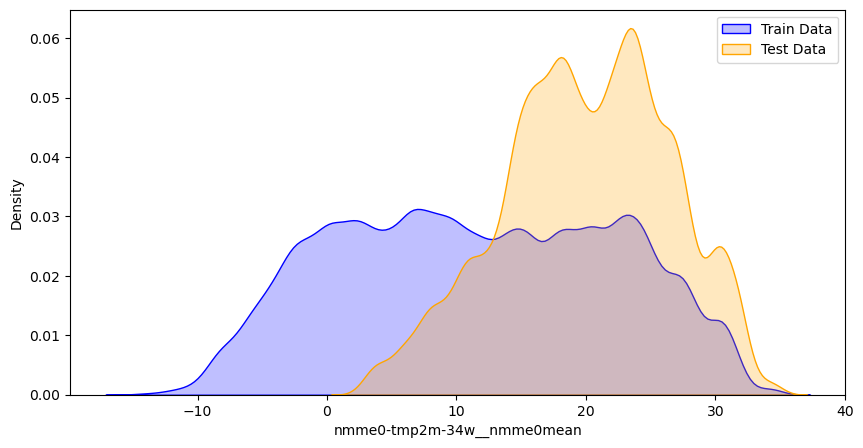

In [18]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='orange', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
#train_target = cc_train['contest-tmp2m-14d__tmp2m']
#test_target = cc_test['contest-tmp2m-14d__tmp2m']
train_target = cc_train['nmme0-tmp2m-34w__nmme0mean']
test_target = cc_test['nmme0-tmp2m-34w__nmme0mean']
train_test_dist(train_target, test_target)

# Visualising Categorical columns

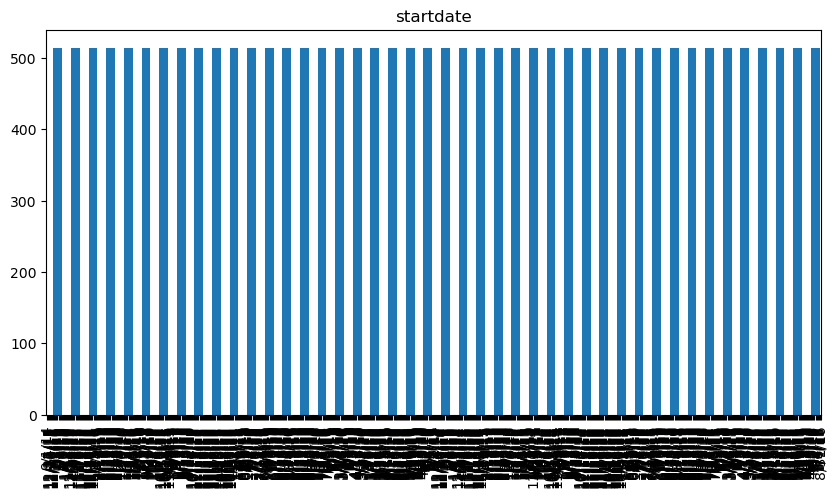

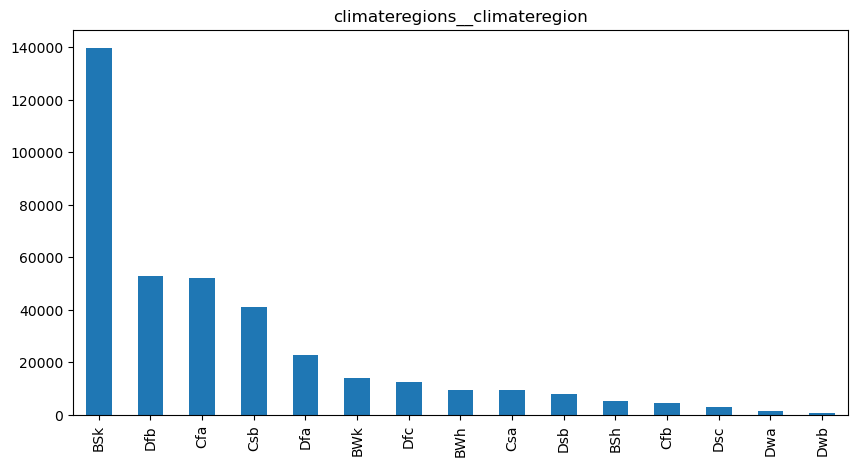

In [19]:

# Plot bar plots for all categorical columns
for column in cc_train.select_dtypes(include=['object']).columns:
    cc_train[column].value_counts().plot(kind='bar', figsize=(10,5))
    plt.title(column)
    plt.show()
    

In [20]:
'''
def plot_boxplots(data, target_column):
    num_cols = data.select_dtypes(exclude=['object']).columns
    for col in num_cols:
        plt.figure(figsize=(10, 5))
        sb.boxplot(x=target_column, y=col, data=data)
        plt.title(col + " vs " + target_column)
        plt.show()
plot_boxplots(cc_train, 'contest-tmp2m-14d__tmp2m')
'''

'\ndef plot_boxplots(data, target_column):\n    num_cols = data.select_dtypes(exclude=[\'object\']).columns\n    for col in num_cols:\n        plt.figure(figsize=(10, 5))\n        sb.boxplot(x=target_column, y=col, data=data)\n        plt.title(col + " vs " + target_column)\n        plt.show()\nplot_boxplots(cc_train, \'contest-tmp2m-14d__tmp2m\')\n'

# Visualising Numerical Columns

In [21]:
# Plot histograms for all numerical columns
num_cols = cc_train.columns
def plot_histograms(data, column_list):
    """
    This function plots histograms based on the number of columns and data provided.
    
    Parameters
    ----------
    data : pandas dataframe
        The data to be plotted.
    column_list : a list
        The list of 10 numerical column names from the dataset..
    
    Returns
    -------
    void
        Displays histograms from matplotlib.
        The histograms that are being plotted are frequency histograms 
        for the numerical columns specified in the column_list parameter .
    """
    num_cols = column_list
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        data[col].hist(bins=50)
        plt.title(col)
        plt.tight_layout()
        plt.show()
        
# plot_histograms(cc_train, num_cols[:10])

# Null Imputation

In [22]:
#cc_train['nmme0-prate-34w__ccsm30'] = cc_train['nmme0-prate-34w__ccsm30'].fillna(cc_train['nmme0-prate-34w__ccsm30'].mean())
#cc_train['nmme0-tmp2m-34w__ccsm30'] = cc_train['nmme0-tmp2m-34w__ccsm30'].fillna(cc_train['nmme0-tmp2m-34w__ccsm30'].mean())
#cc_train['ccsm30'] = cc_train['ccsm30'].fillna(cc_train['ccsm30'].mean())
#cc_train['nmme0-prate-56w__ccsm30'] = cc_train['nmme0-prate-56w__ccsm30'].fillna(cc_train['nmme0-prate-56w__ccsm30'].mean())
#cc_train['nmme-tmp2m-56w__ccsm3'] = cc_train['nmme-tmp2m-56w__ccsm3'].fillna(cc_train['nmme-tmp2m-56w__ccsm3'].mean())
#cc_train['nmme-prate-56w__ccsm3'] = cc_train['nmme-prate-56w__ccsm3'].fillna(cc_train['nmme-prate-56w__ccsm3'].mean())
#cc_train['nmme-tmp2m-34w__ccsm3'] = cc_train['nmme-tmp2m-34w__ccsm3'].fillna(cc_train['nmme-tmp2m-34w__ccsm3'].mean())
#cc_train['nmme-prate-34w__ccsm3'] = cc_train['nmme-prate-34w__ccsm3'].fillna(cc_train['nmme-prate-34w__ccsm3'].mean())

# Feature Engineering

In [23]:
#cc_train['year']=pd.DatetimeIndex(cc_train['startdate']).year 
#cc_train['month']=pd.DatetimeIndex(cc_train['startdate']).month 
#cc_train['day']=pd.DatetimeIndex(cc_train['startdate']).day
#cc_test['year']=pd.DatetimeIndex(cc_test['startdate']).year 
#cc_test['month']=pd.DatetimeIndex(cc_test['startdate']).month 
#cc_test['day']=pd.DatetimeIndex(cc_test['startdate']).day

# Data Preproccessing

In [24]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

    
def fill_na_rows(dataset):
    # Find the columns with missing values
    columns_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
    
    # Impute the missing values with the mean value of that column
    for col in columns_with_missing_values:
        dataset[col].fillna(dataset[col].mean(), inplace=True)
        
    return dataset

def create_new_feat(dataset):
    dataset['year']=pd.DatetimeIndex(dataset['startdate']).year 
    dataset['month']=pd.DatetimeIndex(dataset['startdate']).month 
    dataset['day']=pd.DatetimeIndex(dataset['startdate']).day
    return dataset

def feature_engineering(origin_train, origin_test):
    train, test = origin_train, origin_test
    train = fill_na_rows(train)
    train = create_new_feat(train)
    test = create_new_feat(test)
    train, test = cat_encode(train, test)
    irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    features = [col for col in train.columns if col not in irrelevant_cols]
    #features = [col for col in train.columns]
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    # Initialize the scaler
    #scaler = MinMaxScaler()

    # Fit the scaler to the train data
    #scaler.fit(X)

    # Transform the train data
    #X_train_scaled = scaler.transform(X)

    # Transform the test data
    #X_test_scaled = scaler.transform(X_test)
    
    return X, y, X_test


    
    

# Machine Learning Model
## RandomForestRegressor

Random Forest Regressor is a commonly used machine learning algorithm for regression problems and was chosen in this case because:

- It can handle both linear and non-linear relationships between features and target variables.

- It can handle missing data and is robust to noisy data.

- It is an ensemble method, which means it combines multiple decision trees to produce a more accurate and stable prediction.

- It can provide feature importance scores, which can be useful in identifying the most important features in the data.

- It is easy to implement and provides good results out-of-the-box, especially for large datasets with a large number of features.

These properties make Random Forest Regressor a good choice for a first attempt at solving this regression problem, and it can be a good starting point for further tuning and optimization

# Splittin the data set to train the model

Target variable: `contest-tmp2m-14d__tmp2m`

[WiDS Datathon Challenge](https://www.kaggle.com/competitions/widsdatathon2023/data)

Definition of target variable: 
- the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, is provided

Evaluation Metric:

[Evaluation Reference](https://www.kaggle.com/competitions/widsdatathon2023/overview/evaluation)

Root Mean Squared Error (RMSE)

In [25]:
target="contest-tmp2m-14d__tmp2m"
cc_test_copy = cc_test.copy()

In [26]:
# Split the data into training and test sets
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())



# Checking Correlation

In [27]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [28]:
# afterwards i should print out the columns that are of high importance from the models
# perform PCA and see if it determines the same features as the corr_matrix
# at.96 the score is ~1.24 (~51 columns dropped)
# at .70 the score is ~1.4 (~100+ columns dropped)
# at .80 the score is ~0.968 (100 columns dropped) - but why were these columns so unimportant that dropping it had a better outcome as compared to the other trials with .95 and .70 ?
# **Besides the fact that they were highly correlated - at .70 had more columns but dropping the columns identifed at .70 had a worse score than .80
features_to_drop = identify_correlated(cc_train, .80)

In [29]:
print(len(features_to_drop))
print(features_to_drop)

100
['index', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-

In [30]:
remove_feature = ['index', 'contest-tmp2m-14d__tmp2m']
features_to_drop_v1 = [ele for ele in features_to_drop if ele not in remove_feature]
features_to_drop_v1

['contest-pevpr-sfc-gauss-14d__pevpr',
 'nmme0-tmp2m-34w__cancm30',
 'nmme0-tmp2m-34w__cancm40',
 'nmme0-tmp2m-34w__ccsm30',
 'nmme0-tmp2m-34w__ccsm40',
 'nmme0-tmp2m-34w__cfsv20',
 'nmme0-tmp2m-34w__gfdlflora0',
 'nmme0-tmp2m-34w__gfdlflorb0',
 'nmme0-tmp2m-34w__gfdl0',
 'nmme0-tmp2m-34w__nasa0',
 'nmme0-tmp2m-34w__nmme0mean',
 'contest-wind-h10-14d__wind-hgt-10',
 'nmme-tmp2m-56w__cancm3',
 'nmme-tmp2m-56w__cancm4',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-tmp2m-56w__ccsm4',
 'nmme-tmp2m-56w__cfsv2',
 'nmme-tmp2m-56w__gfdl',
 'nmme-tmp2m-56w__gfdlflora',
 'nmme-tmp2m-56w__gfdlflorb',
 'nmme-tmp2m-56w__nasa',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__cancm3',
 'nmme-prate-34w__cancm4',
 'nmme-prate-34w__ccsm3',
 'nmme-prate-34w__ccsm4',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__gfdl',
 'nmme-prate-34w__gfdlflora',
 'nmme-prate-34w__gfdlflorb',
 'nmme-prate-34w__nasa',
 'nmme-prate-34w__nmmemean',
 'contest-wind-h100-14d__wind-hgt-100',
 'nmme0-prate-56w__cancm30',
 'nmme0-prate-56w__ca

In [31]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))

def ensemble_predict(xgboost_preds, lightgbm_preds):
    # combine the predictions of the two models
    combined_preds = np.mean([xgboost_preds, lightgbm_preds], axis=0)
    return combined_preds

In [32]:
X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)

# Using RandomForestRegressor

**Training and test performance**

In [33]:
'''
# Train the Random Forest Regressor
params = {
    'n_estimators': 5000,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}
regr_rfr = RandomForestRegressor(**params)
regr_rfr.fit(X_train, y_train)
# make predictions on the test data
y_pred_rfr = regr_rfr.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("RMSE:", rmse)
'''

'\n# Train the Random Forest Regressor\nparams = {\n    \'n_estimators\': 5000,\n    \'max_depth\': 10,\n    \'min_samples_split\': 2,\n    \'min_samples_leaf\': 1,\n    \'max_features\': \'sqrt\',\n    \'bootstrap\': True,\n    \'oob_score\': True\n}\nregr_rfr = RandomForestRegressor(**params)\nregr_rfr.fit(X_train, y_train)\n# make predictions on the test data\ny_pred_rfr = regr_rfr.predict(X_test_tts)\n\n# calculate the RMSE\nrmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))\nprint("RMSE:", rmse)\n'

In [34]:
# cc_test_pred = regr_rfr.predict(cc_test_reduced)

In [35]:
# cc_test_copy[target] = cc_test_pred
# cc_test_copy[[target,"index"]].to_csv("rfrpredictions.csv",index = False)

# Using XGBoost

*Gradient Boosted Decision Trees*

XGBoost is short for Extreme Gradient Boosting. The implementation is designed for speed and performance. It is an efficient implementation of the stochastic gradient boosting algorithm.

In [36]:
# create a DMatrix from the training data
#dtrain = xgb.DMatrix(data=X_train, label=y_train)
#dtest = xgb.DMatrix(data=X_test)

### Hyperparameters used
These parameters are used to specify the hyperparameters for a gradient boosting tree (GBT) model in the XGBoost library.

- **base_score**: It is the initial prediction score of all instances, global bias.

- **booster**: It specifies which booster to use for model training. The value 'gbtree' indicates that a tree-based booster will be used.

- **tree_method**: It specifies the method used to build the trees. The value 'gpu_hist' means that the histogram-based algorithm is used to build the trees on a GPU.

- **n_estimators**: It is the number of trees in the forest. The higher the number, the more complex the model becomes, but also the longer it takes to train.

- **early_stopping_rounds**: It is used to stop the training process early when the performance on a validation set starts to degrade. The value 50 indicates that training will be stopped if the performance on the validation set does not improve after 50 iterations.

- **objective**: It defines the loss function to be minimized. The value 'reg:squarederror' means that the model will minimize the mean squared error between the predicted and actual values.

- **max_depth**: It is the maximum depth of the trees in the model. The higher the value, the more complex the model becomes. Note: 2 - 8 is recommended, any higher value than 8 would not provide any more benefits.

- **subsample**: It is the fraction of the training instances used to build each tree in the forest. The lower the value, the simpler the model becomes, but also the more prone to overfitting.

- **colsample_bytree**: It is the fraction of the columns used to build each tree in the forest. The lower the value, the simpler the model becomes, but also the more prone to overfitting.

- **learning_rate**: It is the step size at which the optimizer makes updates to the model weights. A lower value means that the model updates more slowly but with less noise.

- **gpu_id**: It is the GPU device id to use for training. The value 0 indicates that the first GPU in the system will be used.

*Can use StratifiedKfold and gridsearhcv to determine the best combinations of parameters.*

> Note 1: I would like to reduce the value of the n_estimators will maintaining the same rmse or better.

> Note 2: Review the learning curve on the training and validation set

In [37]:

# set up parameters for XGBoost
# list of learning_rates to test [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
params = {'base_score': 0.5, 
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 15000,
          'early_stopping_rounds': 50,
          'objective': 'reg:squarederror',
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'learning_rate': 0.05, 
          'gpu_id': 0}

reg_xgb = xgb.XGBRegressor(**params)

reg_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test_tts, y_test)],
        verbose=100)


# make predictions on the test data
y_pred_xgb = reg_xgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse)


[0]	validation_0-rmse:14.35715	validation_1-rmse:14.33589
[100]	validation_0-rmse:1.24184	validation_1-rmse:1.25592
[200]	validation_0-rmse:1.01415	validation_1-rmse:1.03109
[300]	validation_0-rmse:0.89753	validation_1-rmse:0.91768
[400]	validation_0-rmse:0.81108	validation_1-rmse:0.83485
[500]	validation_0-rmse:0.74990	validation_1-rmse:0.77715
[600]	validation_0-rmse:0.69867	validation_1-rmse:0.72879
[700]	validation_0-rmse:0.65763	validation_1-rmse:0.69083
[800]	validation_0-rmse:0.61796	validation_1-rmse:0.65387
[900]	validation_0-rmse:0.58574	validation_1-rmse:0.62418
[1000]	validation_0-rmse:0.56102	validation_1-rmse:0.60198
[1100]	validation_0-rmse:0.53830	validation_1-rmse:0.58141
[1200]	validation_0-rmse:0.51795	validation_1-rmse:0.56294
[1300]	validation_0-rmse:0.49679	validation_1-rmse:0.54356
[1400]	validation_0-rmse:0.48026	validation_1-rmse:0.52879
[1500]	validation_0-rmse:0.46652	validation_1-rmse:0.51674
[1600]	validation_0-rmse:0.45425	validation_1-rmse:0.50620
[1700]	

In [38]:
cc_test_pred = reg_xgb.predict(cc_test_reduced)

In [39]:
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("xgbpredictions.csv",index = False)

## XGBoost Hyperparameter Tuning

### TODO:

# How does catboost manage

from catboost import CatBoostRegressor
reg_catb  = CatBoostRegressor(n_estimators=2000,eval_metric='RMSE',learning_rate=0.05, random_seed= 42)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)
y_pred_catb = reg_catb.predict(X_test_tts)


cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_catb = reg_catb.predict(X_test)

cc_test_copy_v2[target] = cc_test_pred_catb

cc_test_copy_v2[[target,"index"]].to_csv("catbpredictions.csv",index = False)

# Using lasso and gradientboosting ensemble

This is taking too long. I need to find a way to speed up

# Using Lasso

lasso = Lasso(alpha=0.005, random_state=1, max_iter=1000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test_tts)
cc_test_pred_lasso = lasso.predict(X_test)
cc_test_copy[target] = cc_test_pred_lasso
cc_test_copy[[target,"index"]].to_csv("lassopredictions.csv",index = False)

# Using GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test_tts)
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_gbr = gbr.predict(X_test)
cc_test_copy_v2[target] = cc_test_pred_gbr
cc_test_copy_v2[[target, "index"]].to_csv("gbrpredictions.csv", index = False)

# Using LightGBM

## understanding hyperparameters

[Amazon documentation on LightGBM](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html)

In [40]:
# parametes removed for now: 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5,
# set up parameters for LightGBM
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 6,
          'num_leaves': 31,
          'learning_rate': 0.05,
          'device_type':'gpu',
          'early_stopping_round': 50,
          'n_estimators': 6000}

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test_tts, y_test)],
        verbose=100)

# make predictions on the test data
y_pred_lgb = reg_lgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 1.37369	valid_1's rmse: 1.3856
[200]	training's rmse: 1.11135	valid_1's rmse: 1.12392
[300]	training's rmse: 0.985999	valid_1's rmse: 1.00059
[400]	training's rmse: 0.897139	valid_1's rmse: 0.91388
[500]	training's rmse: 0.830138	valid_1's rmse: 0.848958
[600]	training's rmse: 0.777788	valid_1's rmse: 0.798837
[700]	training's rmse: 0.734912	valid_1's rmse: 0.757696
[800]	training's rmse: 0.700549	valid_1's rmse: 0.725185
[900]	training's rmse: 0.669325	valid_1's rmse: 0.695697
[1000]	training's rmse: 0.642884	valid_1's rmse: 0.67096
[1100]	training's rmse: 0.618493	valid_1's rmse: 0.648237
[1200]	training's rmse: 0.597847	valid_1's rmse: 0.629299
[1300]	training's rmse: 0.580961	valid_1's rmse: 0.613795
[1400]	training's rmse: 0.562886	valid_1's rmse: 0.597227
[1500]	training's rmse: 0.548737	valid_1's rmse: 0.584727
[1600]	training's rmse: 0.533976	valid_1's rmse: 0.571457
[1700]	training's rmse: 0.522304	valid_1's rmse: 0.56115
[1800]	training's rmse: 0.511618

In [41]:
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target,"index"]].to_csv("lgbpredictions.csv",index = False)

## Values predicted from LightGBM

In [42]:
cc_test_copy_v2[target]

0        29.315946
1        29.410218
2        29.372999
3        29.454697
4        29.420671
           ...    
31349     7.103979
31350     7.054869
31351     5.836399
31352     6.137345
31353     6.785142
Name: contest-tmp2m-14d__tmp2m, Length: 31354, dtype: float64

In [43]:
cc_test_copy[target]

0        29.014513
1        28.874136
2        28.936972
3        29.114321
4        29.200417
           ...    
31349     6.872413
31350     7.523914
31351     6.425503
31352     6.323184
31353     7.015501
Name: contest-tmp2m-14d__tmp2m, Length: 31354, dtype: float32

In [44]:
ensemble_preds = cc_test_copy_v2[target]*0.7+cc_test_copy[target]*0.3

# Using Linear Model

In [45]:
# fit the linear regression model to the training data
#model = LinearRegression()
#model.fit(X_train, y_train)

# make predictions on the testing data
#y_pred = model.predict(X_test)

In [46]:
#predictions = regr.predict(cc_test)

In [47]:
#cc_sample.count()

In [48]:
#pred_y.shape

In [49]:
cc_submission = cc_test_copy.copy()
cc_submission[target] = ensemble_preds
cc_submission[[target,"index"]].to_csv('submission.csv', index = False)